In [2]:
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import fastf1 

In [3]:
fastf1.Cache.enable_cache('cache')

In [4]:
bah21 = fastf1.get_session(2021, 'Bahrain', 'R')
bah21.load(telemetry=True, laps=True, weather=True)
bah22 = fastf1.get_session(2022, 'Bahrain', 'R')
bah22.load(telemetry=True, laps=True, weather=True)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.2]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
/home/pav/python/f1_car_following/.venv/lib/python3.10/site-packages/fastf1/core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=False)
/home/pav/python/f1_car_following/.venv/lib/python3.10/site-packages/fastf1/core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([

In [15]:
# load data into a dataframe and filter out laps with any non-green track status
# also filter out first few laps when chaos ensues
df = pl.DataFrame(bah21.laps)
df = df.filter(
    pl.all((
        pl.col('TrackStatus') == '1',
        pl.col('LapNumber') > 5,
        pl.col('IsAccurate') == True
        )
    )
)

In [16]:
# order dataframe by LapStartTime column
df = df.sort('LapStartTime')

In [17]:
# add a column representing the time difference from the driver ahead
df = df.with_columns(
    (pl.col('LapStartTime') - pl.col('LapStartTime').shift()).alias('GapToCarAhead')
)

In [18]:
# create a categorocal column representing the gap group
# where 1 = <0.5s, 2 = <1s, 3 = <1.5s, 4 = <2s, 5 = <2.5s, 6 = <3s when following behind another car
# also convert LapTime to seconds
df = df.with_columns(
    pl.when(pl.col('GapToCarAhead') < pl.duration(milliseconds=500)).then(1)
            .when(pl.col('GapToCarAhead') < pl.duration(seconds=1)).then(2)
            .when(pl.col('GapToCarAhead') < pl.duration(seconds=1, milliseconds=500)).then(3)
            .when(pl.col('GapToCarAhead') < pl.duration(seconds=2)).then(4)
            .when(pl.col('GapToCarAhead') < pl.duration(seconds=2, milliseconds=500)).then(5)
            .when(pl.col('GapToCarAhead') < pl.duration(seconds=3)).then(6).otherwise(None).alias('gap_group'),
    pl.col('LapTime').cast(pl.Int64) / 10**9)

In [19]:
df = df.join(
   df.with_columns(pl.col("LapNumber") + 1)
     .unique(subset=["DriverNumber", "LapNumber"], keep="last", maintain_order=True)
     .select("DriverNumber", "LapNumber", previous_lap = "LapTime"),
   on=["DriverNumber", "LapNumber"],
   how="left"
)

In [20]:
# now filter out records where gap_group is null or previous_lap is null
df = df.filter(
    pl.all(
        (pl.col('gap_group').is_not_null(), pl.col('previous_lap').is_not_null())
    )
)

In [21]:
# add a column for time_lost compared to the previous lap
df = df.with_columns(
    (pl.col('LapTime') - pl.col('previous_lap')).alias('time_lost')
)

# also filter out the laps when driver pitted, i.e. there PitInTime or PitOutTime is not null
df = df.filter(
    pl.any((pl.col('PitInTime').is_null(), pl.col('PitOutTime').is_null()))
)

In [22]:
df.head()

Time,DriverNumber,LapTime,LapNumber,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Stint,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate,GapToCarAhead,gap_group,previous_lap,time_lost
duration[ns],str,f64,f64,duration[ns],duration[ns],duration[ns],duration[ns],duration[ns],duration[ns],duration[ns],duration[ns],f64,f64,f64,f64,bool,str,f64,bool,i64,duration[ns],str,str,str,bool,datetime[ns],duration[ns],i32,f64,f64
50m 51s 421ms,"""44""",96.123,7.0,null,null,30s 775ms,41s 680ms,23s 668ms,49m 46s 73ms,50m 27s 753ms,50m 51s 421ms,229.0,252.0,279.0,289.0,false,"""MEDIUM""",10.0,false,1,49m 15s 298ms,"""Mercedes""","""HAM""","""1""",true,2021-03-28 15:19:15.308,1s 540ms,4,96.169,-0.046
50m 56s 329ms,"""16""",97.148,7.0,null,null,30s 867ms,42s 277ms,24s 4ms,49m 50s 48ms,50m 32s 325ms,50m 56s 329ms,232.0,246.0,276.0,null,false,"""SOFT""",10.0,false,1,49m 19s 181ms,"""Ferrari""","""LEC""","""1""",true,2021-03-28 15:19:19.191,762ms,2,98.294,-1.146
50m 56s 968ms,"""4""",96.906,7.0,null,null,30s 861ms,42s 3ms,24s 42ms,49m 50s 923ms,50m 32s 926ms,50m 56s 968ms,231.0,246.0,291.0,308.0,false,"""SOFT""",10.0,false,1,49m 20s 62ms,"""McLaren""","""NOR""","""1""",true,2021-03-28 15:19:20.072,881ms,2,97.893,-0.987
50m 58s 52ms,"""3""",97.205,7.0,null,null,30s 806ms,42s 284ms,24s 115ms,49m 51s 653ms,50m 33s 937ms,50m 58s 52ms,235.0,253.0,290.0,313.0,false,"""SOFT""",10.0,false,1,49m 20s 847ms,"""McLaren""","""RIC""","""1""",true,2021-03-28 15:19:20.857,785ms,2,97.571,-0.366
50m 59s 134ms,"""14""",97.366,7.0,null,null,30s 534ms,42s 493ms,24s 339ms,49m 52s 302ms,50m 34s 795ms,50m 59s 134ms,231.0,250.0,286.0,null,false,"""SOFT""",10.0,false,1,49m 21s 768ms,"""Alpine""","""ALO""","""1""",true,2021-03-28 15:19:21.778,921ms,2,97.652,-0.286


In [24]:
def get_data_for_gp_and_transform(gp: str, year: int):
    d = fastf1.get_session(year, gp, 'R')
    d.load(telemetry=True, laps=True, weather=True)
    
    # load data into a dataframe and filter out laps with any non-green track status
    # also filter out first few laps when chaos ensues
    df = pl.DataFrame(d.laps)
    df = df.filter(
        pl.all((
            pl.col('TrackStatus') == '1',
            pl.col('LapNumber') > 5,
            pl.col('IsAccurate') == True
            )
        )
    )
    # order dataframe by LapStartTime column
    df = df.sort('LapStartTime')
    
    # add a column representing the time difference from the driver ahead
    df = df.with_columns(
        (pl.col('LapStartTime') - pl.col('LapStartTime').shift()).alias('GapToCarAhead')
    )
        
    # create a categorocal column representing the gap group
    # where 1 = <0.5s, 2 = <1s, 3 = <1.5s, 4 = <2s, 5 = <2.5s, 6 = <3s when following behind another car
    # also convert LapTime to seconds
    df = df.with_columns(
        pl.when(pl.col('GapToCarAhead') < pl.duration(milliseconds=500)).then(1)
                .when(pl.col('GapToCarAhead') < pl.duration(seconds=1)).then(2)
                .when(pl.col('GapToCarAhead') < pl.duration(seconds=1, milliseconds=500)).then(3)
                .when(pl.col('GapToCarAhead') < pl.duration(seconds=2)).then(4)
                .when(pl.col('GapToCarAhead') < pl.duration(seconds=2, milliseconds=500)).then(5)
                .when(pl.col('GapToCarAhead') < pl.duration(seconds=3)).then(6).otherwise(None).alias('gap_group'),
        pl.col('LapTime').cast(pl.Int64) / 10**9)
    
    df = df.join(
    df.with_columns(pl.col("LapNumber") + 1)
        .unique(subset=["DriverNumber", "LapNumber"], keep="last", maintain_order=True)
        .select("DriverNumber", "LapNumber", previous_lap = "LapTime"),
    on=["DriverNumber", "LapNumber"],
    how="left"
    )
    
    # now filter out records where gap_group is null or previous_lap is null
    df = df.filter(
        pl.all(
            (pl.col('gap_group').is_not_null(), pl.col('previous_lap').is_not_null())
        )
    )
    
    # add a column for time_lost compared to the previous lap
    df = df.with_columns(
        (pl.col('LapTime') - pl.col('previous_lap')).alias('time_lost')
    )

    # also filter out the laps when driver pitted, i.e. there PitInTime or PitOutTime is not null
    df = df.filter(
        pl.any((pl.col('PitInTime').is_null(), pl.col('PitOutTime').is_null()))
    )
    return df

In [157]:
def create_linear_model_for_specific_gap_group(df: pl.DataFrame, gap_group: int):
    gap = df.filter(pl.col('gap_group') == gap_group)
    lap_time = gap.select(pl.col('LapTime')).to_numpy()
    prev_lap = gap.select(pl.col('previous_lap')).to_numpy()
    lin = LinearRegression().fit(prev_lap, lap_time)
    return lin

In [26]:
bah22 = get_data_for_gp_and_transform('Bahrain', 2022)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.2]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
/home/pav/python/f1_car_following/.venv/lib/python3.10/site-packages/fastf1/core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=False)
/home/pav/python/f1_car_following/.venv/lib/python3.10/site-packages/fastf1/core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comparison_between_years_time_lost_per_gap_group(df1: pl.DataFrame, df2: pl.DataFrame):
    gaps = [1, 2, 3, 4, 5, 6]
    av_time_lost_1: list[float] = [
        df1.filter(pl.col('gap_group') == gap)
        .select(pl.col('time_lost'))
        .mean().to_numpy()[0][0]
        for gap in gaps
    ]    
    av_time_lost_2: list[float] = [
        df2.filter(pl.col('gap_group') == gap)
        .select(pl.col('time_lost'))
        .mean().to_numpy()[0][0]
        for gap in gaps
    ]   
    labels = ['<0.5s', '<1s', '<1.5s', '<2s', '<2.5s', '<3s']
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    sns.barplot(x=av_time_lost_1, y=labels, ax=axs[0], color='grey')
    sns.barplot(x=av_time_lost_2, y=labels, ax=axs[1], color='orangered')
    plt.show()

core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.2]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
/home/pav/python/f1_car_following/.venv/lib/python3.10/site-packages/fastf1/core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=False)
/home/pav/python/f1_car_following/.venv/lib/python3.10/site-packages/fastf1/core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([

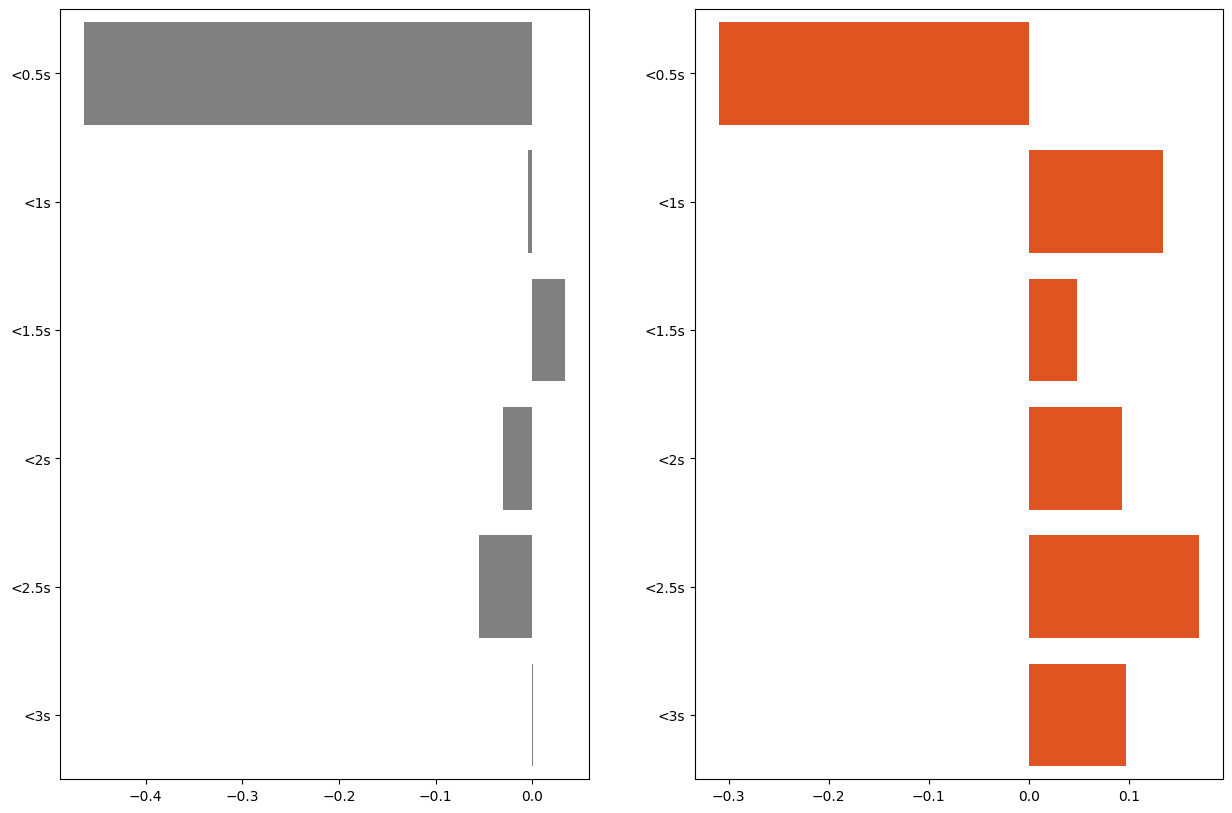

In [57]:
bah21 = get_data_for_gp_and_transform('Bahrain', 2021)
bah22 = get_data_for_gp_and_transform('Bahrain', 2022)
plot_comparison_between_years_time_lost_per_gap_group(bah21, bah22)

core           INFO 	Loading data for Italian Grand Prix - Race [v2.3.2]
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached data found for session_status_data. Loading data...
api            INFO 	Fetching session status data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for track_status_data. Loading data...
api            INFO 	Fetching track sta

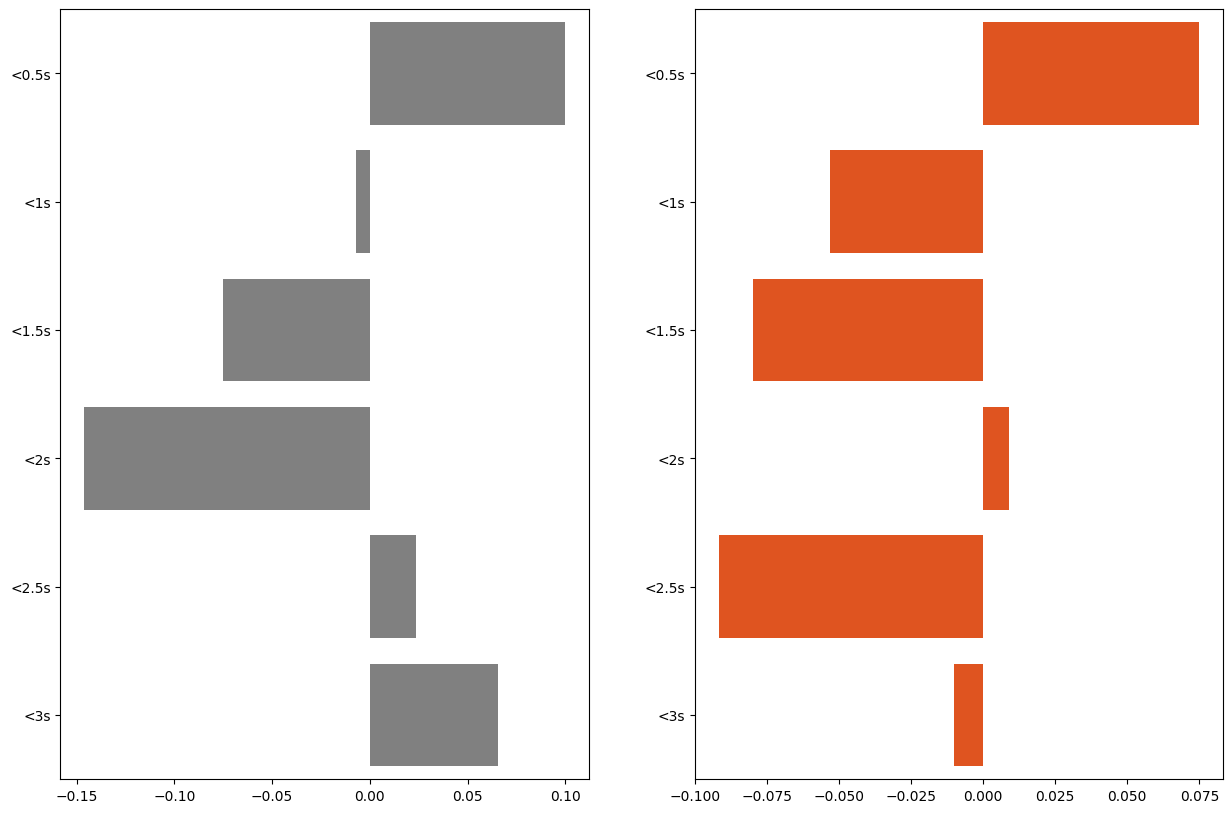

In [58]:
mon21 = get_data_for_gp_and_transform('Monza', 2021)
mon22 = get_data_for_gp_and_transform('Monza', 2022)
plot_comparison_between_years_time_lost_per_gap_group(mon21, mon22)

core           INFO 	Loading data for Monaco Grand Prix - Race [v2.3.2]
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached data found for session_status_data. Loading data...
api            INFO 	Fetching session status data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for track_status_data. Loading data...
api            INFO 	Fetching track stat

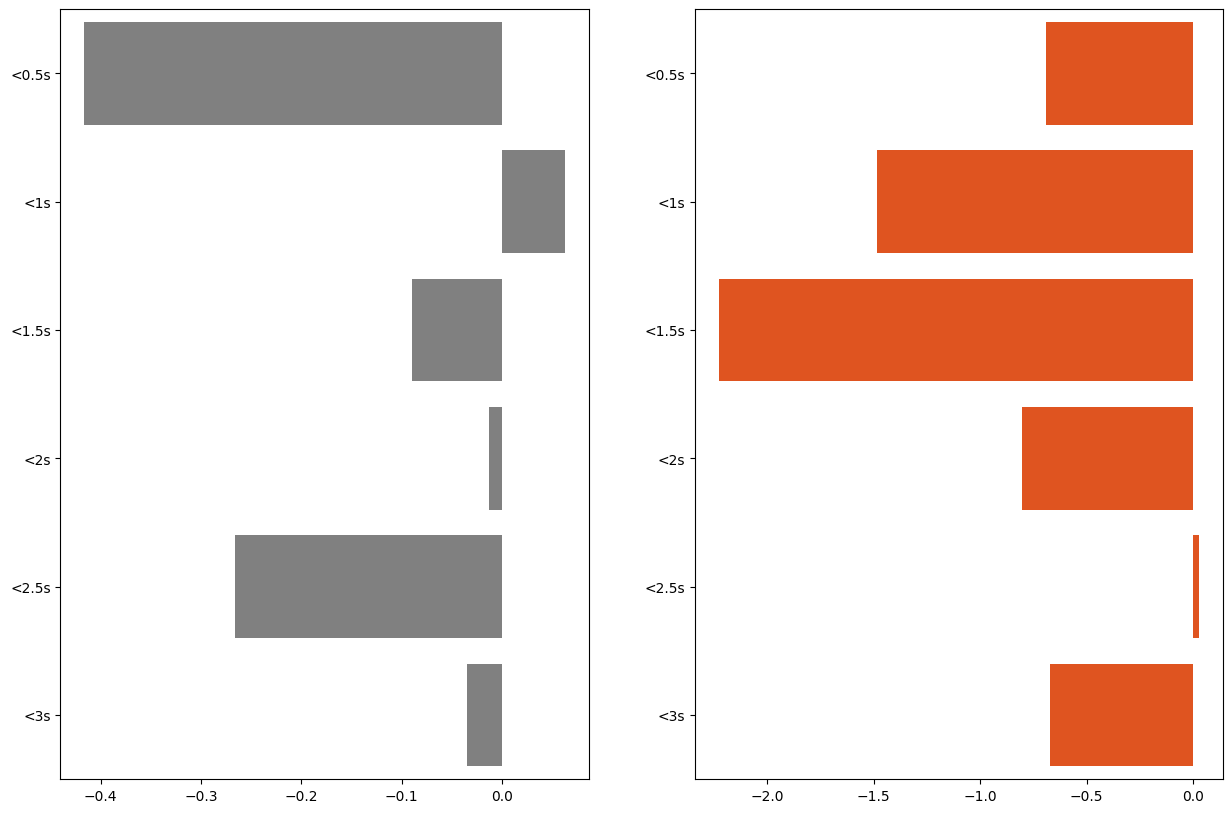

In [59]:
mnk21 = get_data_for_gp_and_transform('Monaco', 2021)
mnk22 = get_data_for_gp_and_transform('Monaco', 2022)
plot_comparison_between_years_time_lost_per_gap_group(mnk21, mnk22)

core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v2.3.2]
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api         WARNING 	Driver 47: Ignoring late data for a previously processed lap.The data may contain errors (previous: 42; current 43)
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached data found for session_status_data. Loading data...
api            INFO 	Fetching session status data...
api            INFO 	Data has bee

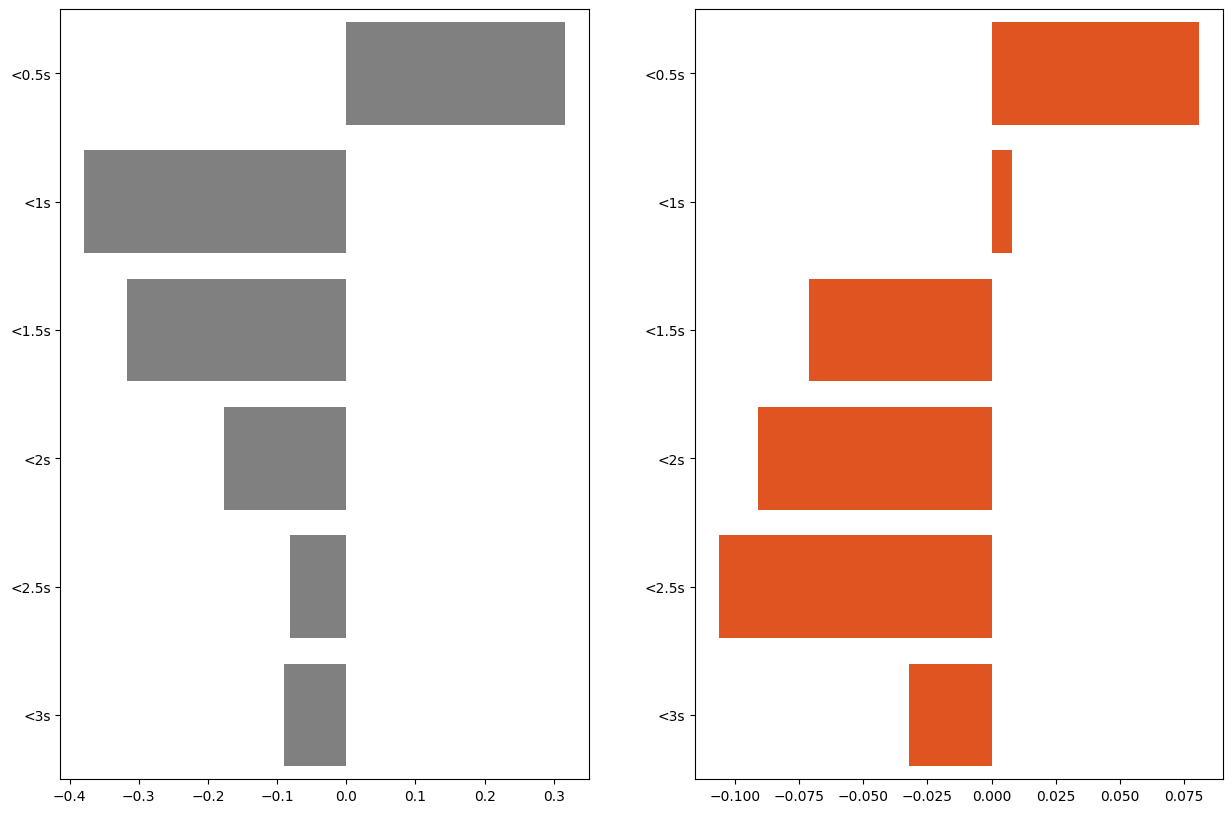

In [65]:
bak21 = get_data_for_gp_and_transform('Baku', 2021)
bak22 = get_data_for_gp_and_transform('Baku', 2022)
plot_comparison_between_years_time_lost_per_gap_group(bak21, bak22)

In [66]:
from functools import reduce

all_gp = ['Bahrain', 'Bacelona', 'Monaco', 'Baku', 'France', 'Austria', 'Silverstone', 'Hungary', 'Belgium', 'Zandvoort', 'Monza', 'Texas', 'Mexico', 'Brazil', 'Abu Dhabi']
all_gp_21 = [get_data_for_gp_and_transform(gp, 2021) for gp in all_gp]
all_gp_22 = [get_data_for_gp_and_transform(gp, 2022) for gp in all_gp]

core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.2]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
/home/pav/python/f1_car_following/.venv/lib/python3.10/site-packages/fastf1/core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=False)
/home/pav/python/f1_car_following/.venv/lib/python3.10/site-packages/fastf1/core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([

In [85]:
all_gp_21 = [i.with_columns(pl.col('LapNumber').cast(pl.Int64)) for i in all_gp_21]
all_gp_22 = [i.with_columns(pl.col('LapNumber').cast(pl.Int64)) for i in all_gp_22]

gp21_combined = pl.concat(all_gp_21)
gp22_combined = pl.concat(all_gp_22)

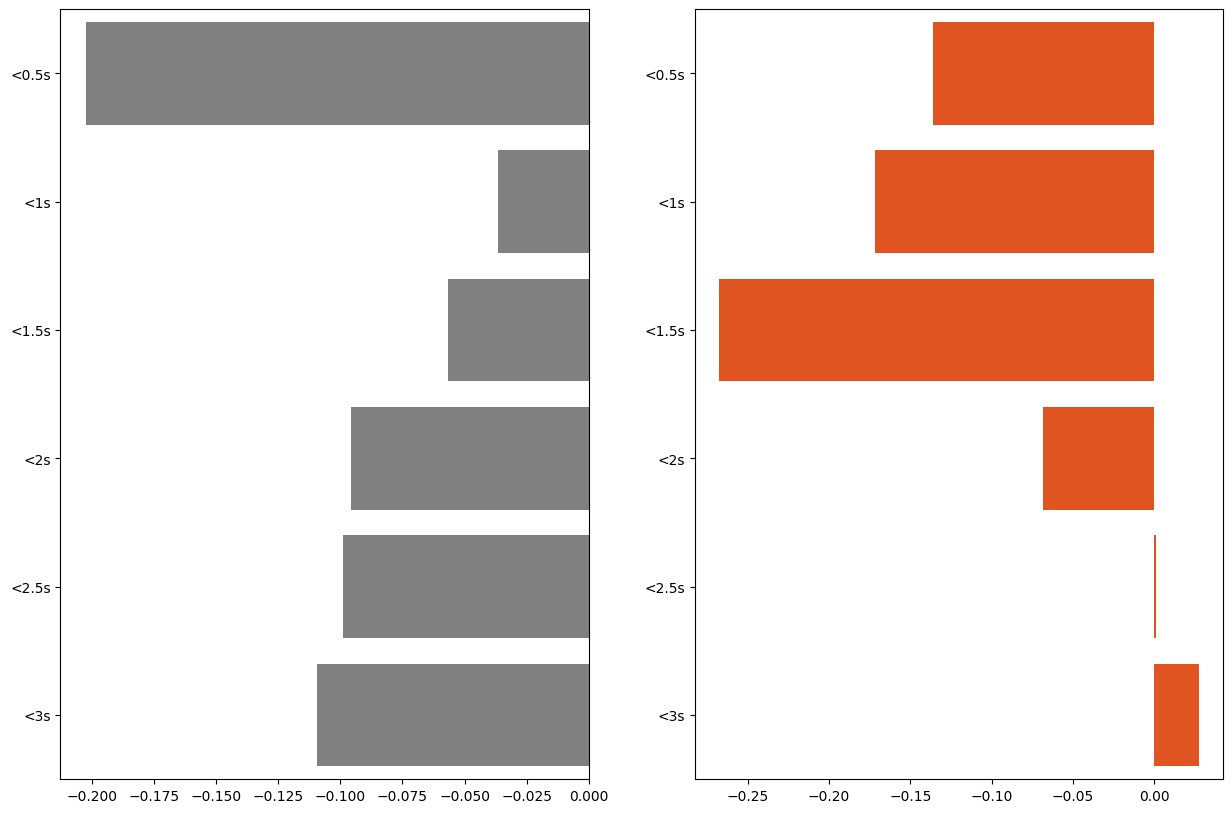

In [86]:
plot_comparison_between_years_time_lost_per_gap_group(gp21_combined, gp22_combined)